In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import PIL
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

# needed only for MAC
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# creating cude device to run on GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: {}'.format(device))
if str(device) == 'cuda':
  print(torch.cuda.get_device_name())

# copy data folder from drive to this machine
!cp /content/drive/MyDrive/64_mat.zip /content/64_mat.zip
!unzip /content/64_mat.zip

images = np.load('64_mat.npy')
print(images.shape)

device: cuda
Tesla T4
Archive:  /content/64_mat.zip
  inflating: 64_mat.npy              
(56611, 64, 64, 3)


In [2]:
def generate_noise(batch_size):
  means = torch.tensor(np.zeros((batch_size,1,1,24))).float() 
  vars = torch.tensor(np.ones((batch_size,1,1,24))).float()
  noise = torch.normal(means,vars)
  noise[noise > 3] = 3
  noise[noise < -3] = -3
  return noise

class att_conv(nn.Module):
  def __init__(self, in_c, out_c):
    super(att_conv, self).__init__()
    self.in_c = in_c
    self.out_c = out_c
    self.conv_init = nn.Conv2d(in_c, out_c, 3, padding=1, stride=1)
    self.conv_qkv = nn.Conv2d(in_c, in_c*2+out_c, 5, padding=2, stride=2)
    self.attn_out = nn.Conv2d(int(out_c/4), out_c , 1, padding=0, stride=1)
    self.sigma = nn.Parameter(torch.scalar_tensor(0))

  def forward(self, x):
    x = x.swapdims(1,3)
    conv_init = self.conv_init(x) 
    q, k, v = self.compute_qkv(x)
    logits = torch.bmm(q.transpose(1,2), k)
    weights = F.softmax(logits, dim=-1)
    att_out = torch.matmul(weights, v.transpose(1,2)).reshape((x.shape[0], -1 ,x.shape[2], x.shape[3]))
    att_out = self.attn_out(att_out)
    output = (att_out*self.sigma) + conv_init
    output = output.swapdims(1,3)
    return output

  def compute_qkv(self, x):
    qkv = self.conv_qkv(x)
    q, k ,v = torch.split(qkv, [self.in_c, self.in_c, self.out_c], dim=1)
    q = q.reshape((-1, self.in_c, q.shape[2] * q.shape[3]))
    k = k.reshape((-1, self.in_c, k.shape[2] * k.shape[3]))
    v = v.reshape((-1, self.out_c, v.shape[2] * v.shape[3]))
    return q,k,v

class upsampling_block(nn.Module):
  def __init__(self, layers_in, layers_out):
    super(upsampling_block, self).__init__()
    self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
    self.conv = att_conv(layers_in, layers_out)
    self.act = torch.nn.SiLU()
    self.bn = nn.BatchNorm2d(layers_out)

  def forward(self, x): 
    x = x.swapdims(1,3)
    x = self.upsample(x)
    x = x.swapdims(1,3)
    x = self.conv(x)
    x = x.swapdims(1,3)
    x = self.bn(x)
    x = x.swapdims(1,3)
    x = self.act(x)
    return x

class downsampling_block(nn.Module):
  def __init__(self, layers_in, layers_out):
    super(downsampling_block, self).__init__()
    self.downsample = nn.MaxPool2d(2)
    self.conv = att_conv(layers_in, layers_out)
    self.act = torch.nn.SiLU()

  def forward(self, x):
    x = self.conv(x)
    x = self.act(x)
    x = x.swapdims(1,3)
    x = self.downsample(x)
    x = x.swapdims(1,3)
    return x

class generator(nn.Module):
  def __init__(self):
    super(generator, self).__init__()
    self.upsample1 = upsampling_block(24,256) # 1 -> 2
    self.upsample2 = upsampling_block(256,256) # 2 -> 4
    self.upsample3 = upsampling_block(256,256) # 4 -> 8
    self.upsample4 = upsampling_block(256,256) # 8 -> 16
    self.upsample5 = upsampling_block(256,256) # 16 -> 32
    self.upsample6 = upsampling_block(256,256) # 32 -> 64
    self.finel = nn.Conv2d(256,3, 3, padding=1, stride=1)
  def forward(self, x): 
    x = self.upsample1(x)
    x = self.upsample2(x)
    x = self.upsample3(x)
    x = self.upsample4(x)
    x = self.upsample5(x)
    x = self.upsample6(x)
    x = x.swapdims(1,3)
    x = self.finel(x)
    return x

class descriminator(nn.Module):
  def __init__(self):
    super(descriminator, self).__init__()
    self.downsample1 = downsampling_block(3,96) # 64 -> 32
    self.downsample2 = downsampling_block(96,96) # 32 -> 16
    self.downsample3 = downsampling_block(96,96) # 16 -> 8
    self.downsample4 = downsampling_block(96,96) # 8 -> 4
    self.downsample5 = downsampling_block(96,96) # 4 -> 2
    self.downsample6 = downsampling_block(96,128) # 2 -> 1
    self.finel = nn.Conv2d(128,1, 1, padding=0, stride=1)
  def forward(self, x): 
    x = self.downsample1(x)
    x = self.downsample2(x)
    x = self.downsample3(x)
    x = self.downsample4(x)
    x = self.downsample5(x)
    x = self.downsample6(x)
    x = x.swapdims(1,3)
    x = self.finel(x)
    x = x.swapdims(1,3)
    return x

def wasserstein_loss(y_true, y_pred):
  """both are vectors, y_true are the target numbers for each example and y_pred are the outputs of the discriminator"""
  return torch.mean(y_true*y_pred)

class wgan(nn.Module):
  def __init__(self):
    super(wgan, self).__init__()
    self.g = generator()
    self.d = descriminator()

  def forward(self, x):
    x = self.g(x)
    x = x.swapdims(1,3)
    x = self.d(x)
    return x

def merge_images_and_predict(images, model, batch_size=32):
  z = generate_noise(batch_size).float().to(device)
  fake_images_output = model.g(z)
  alpha = torch.rand((batch_size,1,1,1)).half().to(device)
  mean_images = images*alpha+fake_images_output*(1-alpha)
  mean_images.requires_grad = True
  mean_images = mean_images.swapdims(1,3)
  y_pred = model.d(mean_images).squeeze()
  return mean_images, y_pred

def gradiant_panelty(mean_images, y_pred):
  ones = torch.ones_like(y_pred)
  grad_params = torch.autograd.grad(outputs=y_pred,inputs=mean_images,create_graph=True,grad_outputs=ones)[0]
  grad_params = grad_params.reshape(grad_params.shape[0], -1)
  gradient_norm = grad_params.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
  return gradient_penalty

In [3]:
class Dataset(torch.utils.data.Dataset):
  """create a torch dataset to load the data into the model during training"""

  def __init__(self, data):
    self.data = data

  def __len__(self):
        return self.data.shape[0]

  def __getitem__(self, i):
        im = self.data[i,:,:,:]
        return im
dataset = Dataset(images)

In [4]:
BATCH_SIZE = 32
model = wgan().to(device)
model.load_state_dict(torch.load('/content/att_model_24.pth'))
loss_list_generator = []
loss_list_discrimanotr = []
opt_g = optim.RMSprop(model.g.parameters(), lr=0.00005)
opt_d = optim.RMSprop(model.d.parameters(), lr=0.00005)

In [112]:
N_EPOCHS = 50
model.train()
for epoch in range(N_EPOCHS):

  data_gen = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
  for i, batch in enumerate(data_gen):
    batch = batch.float().to(device)
    #batch = batch.swapaxes(1,3)
    
    if i % 30 == 0 and i > 1:
       print(f'epoch {epoch}, loss D: {np.mean(loss_list_discrimanotr)}, loss G: {np.mean(loss_list_generator)}')
       loss_list_generator = []
       loss_list_discrimanotr = []
    
    # train D 5 times
    for _ in range(5):
      opt_d.zero_grad() 
      z = generate_noise(BATCH_SIZE).to(device)
      fake_images_output = model(z).squeeze()
      real_images_output = model.d(batch).squeeze()
      predictions = torch.cat([fake_images_output,real_images_output])
      y_true = torch.ones(BATCH_SIZE*2).to(device)
      y_true[:BATCH_SIZE] *= -1
      loss_w = wasserstein_loss(y_true, predictions)
      loss_list_discrimanotr.append(loss_w.item())
      batch = batch.swapaxes(1,3)
      merged, y_pred = merge_images_and_predict(batch, model, BATCH_SIZE)
      batch = batch.swapaxes(1,3)
      loss_panelty = gradiant_panelty(merged, y_pred)
      loss = loss_w + loss_panelty*10
      loss.backward()
      opt_d.step()
      

    # train G once 
    opt_g.zero_grad()
    z = generate_noise(BATCH_SIZE).to(device)
    fake_images_output = model(z).squeeze()
    y_true = torch.ones(BATCH_SIZE).to(device)
    loss_w = wasserstein_loss(y_true, fake_images_output)
    loss_list_generator.append(loss_w.item())
    batch = batch.swapaxes(1,3)
    merged, y_pred = merge_images_and_predict(batch, model, BATCH_SIZE)
    batch = batch.swapaxes(1,3)
    loss_panelty = gradiant_panelty(merged, y_pred)
    loss = loss_w + loss_panelty*10
    loss.backward()
    opt_g.step()

epoch 0, loss D: -2.671466149969729, loss G: 1.7152644477107308
epoch 0, loss D: -2.0360065033038457, loss G: -2.6297107127805552
epoch 0, loss D: -2.4890898084640503, loss G: 1.2151748836040497
epoch 0, loss D: -2.635093557039897, loss G: 2.6977897475163144
epoch 0, loss D: -2.129135849078496, loss G: -1.9439922094345092
epoch 0, loss D: -2.4070102381706238, loss G: 1.8797679536044598
epoch 0, loss D: -2.337466045220693, loss G: 0.3744730785489082
epoch 0, loss D: -2.4821716070175173, loss G: 1.0231770594914755
epoch 0, loss D: -2.136891239484151, loss G: -0.5487101296583812
epoch 0, loss D: -2.7175007446606956, loss G: 2.191790170967579
epoch 0, loss D: -2.537192877133687, loss G: 2.311905699968338
epoch 0, loss D: -2.437019557952881, loss G: 1.6427694896856944
epoch 0, loss D: -2.732781092325846, loss G: 2.1746498410900434
epoch 0, loss D: -1.826050010273854, loss G: -3.8424100264906884
epoch 0, loss D: -2.491547289689382, loss G: 1.8652081434925398
epoch 0, loss D: -2.6253216163317

KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.88338


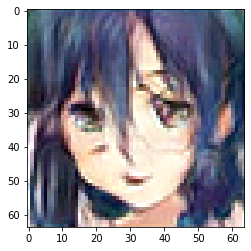

In [83]:
model.eval()
z4 = generate_noise(10).float().to(device)
fake_images = model.g(z4)
scores = model.d(fake_images.swapaxes(1,3))
fake_images = fake_images[0,:,:,:].float().cpu().detach().numpy()
fake_images = fake_images.swapaxes(0,2)
plt.imshow(fake_images)
print(scores[0].float().cpu().detach().numpy()[0][0][0])

In [119]:
torch.save(model.state_dict(), '/content/att_model_24.pth')

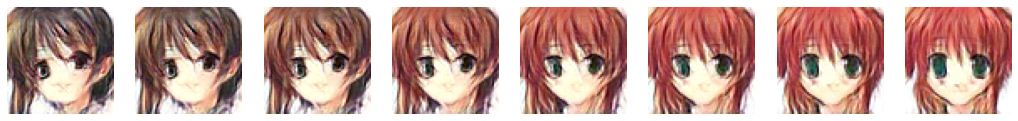

In [17]:
import logging
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)
z = generate_noise(BATCH_SIZE).to(device)
f, e = plt.subplots(1,8, figsize=(18,5))
for i in range(8):
  t = torch.clone(z)
  t[0,:,:,2] += (i-4)
  a1 = model.g.upsample1(t).squeeze()
  a2 = model.g.upsample2(a1).squeeze()
  a3 = model.g.upsample3(a2).squeeze()
  a4 = model.g.upsample4(a3).squeeze()
  a5 = model.g.upsample5(a4).squeeze()
  a6 = model.g.upsample6(a5).squeeze()
  a6 = a6.swapdims(1,3)
  a7 = model.g.finel(a6).squeeze()
  a7 = a7.swapdims(1,3)
  e[i].imshow(a7[0,:,:,:].cpu().detach().numpy())
  e[i].axis('off')
logger.setLevel(old_level)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9


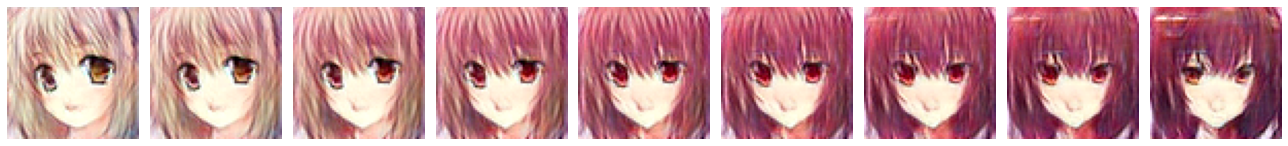

In [33]:
def transformer(z1, z2, n=5):
  ims = []
  # create z1 image
  im = model.g(z1).cpu().detach().numpy()
  t = np.copy(im)
  t = t + -1*(t.min())
  t = t / t.max()
  t = t * 255
  t = np.uint8(t)
  ims.append(t)
  # create intermiddiate images
  z_new = torch.clone(z1)
  for i in range(n-2):
    z_new = z_new + (z2/n) - (z1/n)
    im = model.g(z_new).cpu().detach().numpy()
    t = np.copy(im)
    t = t + -1*(t.min())
    t = t / t.max()
    t = t * 255
    t = np.uint8(t)
    ims.append(t)
  # create z2 image
  im = model.g(z2).cpu().detach().numpy()
  t = np.copy(im)
  t = t + -1*(t.min())
  t = t / t.max()
  t = t * 255
  t = np.uint8(t)
  ims.append(t)
  print(len(ims))
  return ims

#z1 = generate_noise(32).float().to(device)
#z2 = generate_noise(10).float().to(device)
n = 9
ims = transformer(z, z2, n=n)
transition = [ims[x][0,:,:,:] for x in range(len(ims))]
f, a = plt.subplots(1,n,figsize=(18,5))
for i in range(n):
  a[i].imshow(transition[i].swapaxes(0,2))
  a[i].axis('off')
f.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


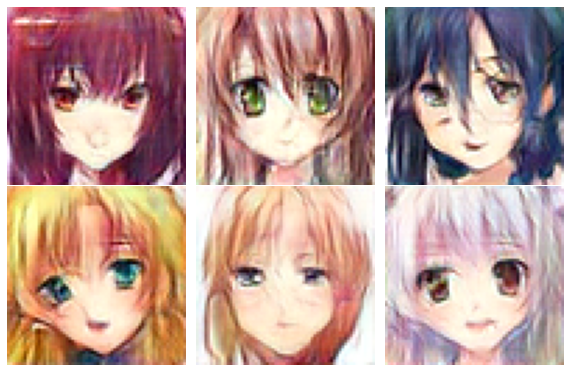

In [84]:
f, a = plt.subplots(2,3,figsize=(8,5))
zs = [z2, z3, z4, z5, z6, z7]
c = 0
for i in range(2):
  for j in range(3):
    # z2 = generate_noise(10).float().to(device)
    fake_images = model.g(zs[c])
    c += 1
    fake_image = fake_images[0,:,:,:].float().cpu().detach().numpy()
    fake_image = fake_image.swapaxes(0,2)
    a[i,j].imshow(fake_image)
    a[i,j].axis('off')
f.tight_layout(pad=0.1)